In [79]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, LSTM, Conv1D, Dropout, GlobalAveragePooling1D, Dense
from keras.layers import BatchNormalization, MaxPooling1D
import glob

from ConvertPy2Hex import hex_to_c_array

clean_df = pd.read_csv('F:/OneDrive - kaist.ac.kr/2023S/CS565/input/merged_sensor_data_clean.csv')
dirty_df = pd.read_csv('F:/OneDrive - kaist.ac.kr/2023S/CS565/input/merged_sensor_data_dirty.csv')

# Assign labels: Clean as 0, Dirty as 1
clean_df['Label'] = 0
dirty_df['Label'] = 1

# Concatenate clean and dirty data
combined_df = pd.concat([clean_df, dirty_df])
print(combined_df.columns)

# # Initialize arrays for input data and labels
n_steps = 58

def create_dataset(X, y, time_steps=1, overlap_ratio=0.5):
    Xs, ys = [], []
    step_size = int(time_steps * (1-overlap_ratio)) # calculate the step size based on the overlap ratio
    for i in range(0, len(X) - time_steps, step_size):  # notice the 'step_size' in range()
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps - 1]) # this will take the label that aligns with the last step in the window
    return np.array(Xs), np.array(ys)

# Define the time steps and overlap ratio
OVERLAP_RATIO = 0.5

# Reshape to [samples, time_steps, n_features]
X, y = create_dataset(
    combined_df[['x_ACC', 'y_ACC', 'z_ACC', 'x_GYR', 'y_GYR', 'z_GYR', 'speed_knots', 'diff_speed']],
    combined_df['Label'],
    n_steps,
    OVERLAP_RATIO
)

Index(['time_x', 'x_ACC', 'y_ACC', 'z_ACC', 'x_GYR', 'y_GYR', 'z_GYR', 'bin',
       'time_y', 'speed_knots', 'diff_speed', 'Label'],
      dtype='object')


In [80]:
num_features = 8  # number of features

# Build the model
model = Sequential()

# Add 1D Convolutional Layers
model.add(Conv1D(128, kernel_size=3, activation='relu', input_shape=(n_steps, num_features)))
model.add(Dropout(0.5))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(16, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())  # Flatten the 2D outputs into 1D 

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = []
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    # Fit the model
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    history.append(model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), verbose=2))

Epoch 1/10
22/22 - 2s - loss: 0.1471 - accuracy: 0.9651 - val_loss: 0.0023 - val_accuracy: 1.0000 - 2s/epoch - 74ms/step
Epoch 2/10
22/22 - 0s - loss: 0.0035 - accuracy: 0.9971 - val_loss: 8.7985e-04 - val_accuracy: 1.0000 - 155ms/epoch - 7ms/step
Epoch 3/10
22/22 - 0s - loss: 7.5926e-04 - accuracy: 1.0000 - val_loss: 1.9143e-04 - val_accuracy: 1.0000 - 153ms/epoch - 7ms/step
Epoch 4/10
22/22 - 0s - loss: 3.6188e-04 - accuracy: 1.0000 - val_loss: 2.6651e-05 - val_accuracy: 1.0000 - 156ms/epoch - 7ms/step
Epoch 5/10
22/22 - 0s - loss: 2.2765e-05 - accuracy: 1.0000 - val_loss: 8.6560e-06 - val_accuracy: 1.0000 - 473ms/epoch - 22ms/step
Epoch 6/10
22/22 - 1s - loss: 3.0179e-06 - accuracy: 1.0000 - val_loss: 5.1912e-06 - val_accuracy: 1.0000 - 525ms/epoch - 24ms/step
Epoch 7/10
22/22 - 0s - loss: 4.3123e-06 - accuracy: 1.0000 - val_loss: 2.1071e-07 - val_accuracy: 1.0000 - 409ms/epoch - 19ms/step
Epoch 8/10
22/22 - 1s - loss: 4.4258e-07 - accuracy: 1.0000 - val_loss: 5.6443e-08 - val_accur

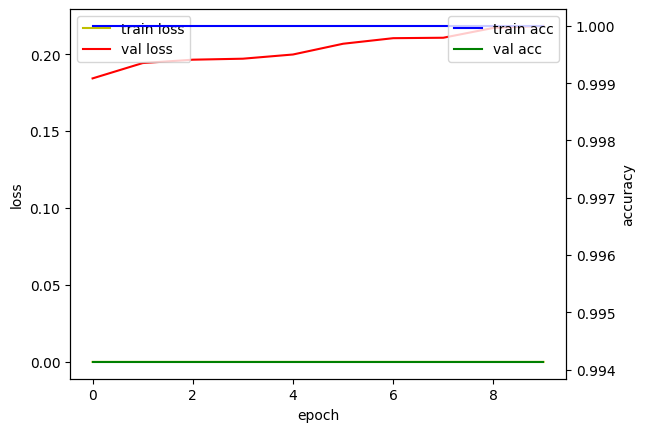

In [81]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

hist = history[1]

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

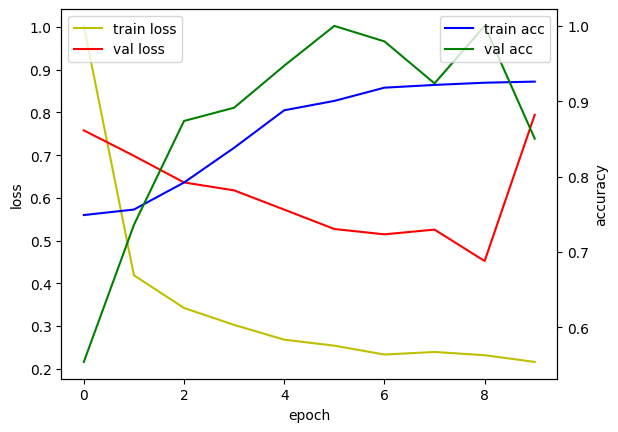

In [82]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

hist = history[3]

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [89]:
def representative_dataset():
  # put your dataset format
  for i in range(len(X_train)):
    yield [np.array(X_train[i:i+1], dtype=np.float32)]
    
# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Song\AppData\Local\Temp\tmpbmue_win\assets


INFO:tensorflow:Assets written to: C:\Users\Song\AppData\Local\Temp\tmpbmue_win\assets
c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [90]:
open('model.tflite', 'wb').write(tflite_model)

49472

In [91]:
# Write TFLite model to a C source (or header) file
with open('model.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, 'g_model'))

In [92]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()